## Fitting method

## Control Variables : <font color = 'sky blue'> $n_e,n_+,n_-,T_e, T_+,T_-, m_+,m_-$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br><br>
    
Number of control variables can be reduced by set $m_+,m_-$ and $n_+ =n_e+n_-$ <br>
Ion composition setup : $SF_5^+,SF_5^-$ and m=127AMU<br>
Fitting error within 5%

In [7]:
import numpy as np
from scipy.optimize import fsolve
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import ldfparser
from scipy.integrate import solve_ivp
from scipy.special import erfc

In [8]:
workDir = './211216(SF6)/bias (float) 70G/'
parser = ldfparser.LDF(workDir)
ldf_files = parser.ldf_paths()

In [2]:
distances, nes, nms, alphas, Vps, Tes = [], [], [], [], [], []

for file in ldf_files:
    IV, eedf, result = parser.pull_attr(file, need_return=True)
    print(file)
    distance = float(file.split('/')[-1][:-4])
    #distance = float(file.split('/')[-1][:-4])
    ne = result['Ne'][0]
    Te = result['eepf_Te'][0]
    Isat = result['Isat'][0]
    Vsat = result['Vsat'][0]
    Vp = result['Vp'][0]
    
    Vps.append(Vp)
    alphas.append(alpha)
    nes.append(ne)
    nms.append(nm)
    distances.append(distance)
    Tes.append(Te)

./211216(SF6)/bias (float) 70G/0.ldf


NameError: name 'alpha' is not defined

## Model Setup

In [1]:
#######################
## Physical Constant ##
#######################
e = 1.6e-19 # electron charge [C]
epsilon_0 = 8.854e-12 # permittivity of vacuum [F/m]
kB = 1.38e-23 #Bolzmann const [kg m2/s2/K]
Mp = 127*1.67e-27 # mass of positive ion [kg] SF5+
Mn = 127*1.67e-27 # mass of negative ion [kg] SF5-
Me = 9.11e-31 # mass of electron [kg]
hr = 0.6 # h-factor
rp = 25e-6 # probe radius [m]
lp = 6e-3 # probe length [m]
Ap = 2*np.pi*lp*rp + 2*np.pi*rp**2 # probe surface area[m2]

NameError: name 'np' is not defined

## 계산될 Parameter

In [ ]:
def solve_r_sh(V, n_e, n_m, Te, Tm, Vp):
    

In [14]:
def solve_as(Te, Tm, a_0):
    def eqn21(a_s):
        return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+Te/Tm*a_s)*(1-Te/Tm))
    a_s = max(fsolve(eqn21,np.logspace(-4,2,7)))
    return a_s

def Seff(V, n_e, n_m, Te, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    J = hr*n_p*e*uBp
    r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/Me)*(abs(V-Vp))**1.5/J)
    r_sh = r_sh + rp
    #return 2*np.pi*r_sh*lp + 2*np.pi*r_sh**2
    return 10*(V-Vp)*Ap

def I_p(V, n_e, n_m, Te, Tp, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    if Vp > V:
        I = -hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
    else:
        I_Vp = -hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
        I = I_Vp*np.exp(-(V-Vp)/Tp)
    return I
    
def I_e(V, n_e, Te, Vp):
    ve = np.sqrt(8*e*Te/np.pi/Me)
    if Vp > V:
        I = e*Ap*n_e*ve/4*np.exp(-(Vp - V)/Te)
    else:
        I = e*Ap*n_e*ve/2*(2*np.sqrt((V-Vp)/Te/np.pi)+1/2*np.exp((V-Vp)/Te)*erfc((V-Vp)/Te))
    return I
    
def I_n(V, n_e, n_m, Te, Tm, Vp):
    uBn = np.sqrt(e*Tm/Mn)
    if Vp > V:
        I_Vp = hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp) # Seff(V) function 만들기
        I = I_Vp*np.exp(-(Vp - V)/Tm)
        #print('I: {:.4e}'.format(I))
    else:
        I = hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp)
        #print('I: {:.4e}'.format(I))
    return I

In [15]:
Vp = 0
ne = 1e16
nm = 7e17
Te = 6
Tp = 0.4
Tm = 0.3

In [16]:
V_list1 = np.linspace(-5, 0, 100)
V_list2 = np.linspace(0,5,100)
V_list = np.unique(np.concatenate((V_list1,V_list2)))
I_list, I_p_list, I_e_list, I_n_list = [], [], [], []

for V in V_list:
    I_p_list.append(I_p(V, ne, nm, Te, Tp, Tm, Vp))
    I_e_list.append(I_e(V, ne, Te, Vp))
    I_n_list.append(I_n(V, ne, nm, Te, Tm, Vp))
    I_list.append(I_p(V, ne, nm, Te, Tp, Tm, Vp) + I_e(V, ne, Te, Vp) + I_n(V, ne, nm, Te, Tm, Vp))

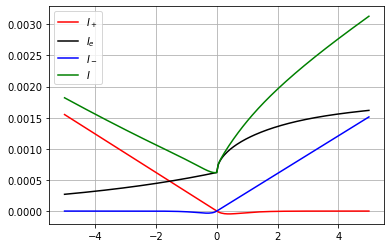

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(V_list, I_p_list, c='r')
plt.plot(V_list, I_e_list, c='k')
plt.plot(V_list, I_n_list, c='b')
plt.plot(V_list, I_list, c='g')
plt.grid(1)
plt.legend(['$I_+$', '$I_e$', '$I_-$', '$I$'])